# Query code on PubMED

Query I am using:

((machine learning[MeSH Terms] OR natural language processing[MeSH Terms] OR cohort analysis OR phenotype[MeSH Terms]) 

AND (electronic health records[MeSH Terms] OR electronic medical records[MeSH Terms]))

I found that no results with keywords: "Phenotypic", "Phenotyping", "EHR", "EMR"

# Step 1: Merge abstract with other basic information of these papers

File saved as 'new_machine_result.csv'

import re

with open('abstract-machinelea-set.txt') as f:
    i = 1
    flag = False
    abstract_abs = []
    abstract_tmp = []
    write_abstract = False
    
    PMID_abs = []
    
    for index, line in enumerate(f):
        if (write_abstract):
            flag = False
            if (not bool(line.strip())): 
                write_abstract = False 
                abstract_abs.append(' '.join(abstract_tmp))
                abstract_tmp = []
                continue 
            else: 
                abstract_tmp.append(line)
                #print(abstract_tmp)
        

        if (line[:1] in '0123456789'):
            if (int(re.search('^[0-9]+', line).group()) == i):
                #print(line)
                i = i + 1
                space_count = 0
                flag = True
                
        if (flag):
            if (not bool(line.strip())):
                space_count = space_count + 1
                #print(space_count, flag)
            
            if (space_count == 4):
                write_abstract = True
                #print(write_abstract)   
                
        ##################################
        if (line[:4] == "PMID"):
            PMID_abs.append(re.findall(r'\d+', line)[0])
            
    print(abstract_abs[0])

In [2]:
import pandas as pd
df = pd.read_csv('csv-machinelea-set.csv')
#df.head()

In [3]:
# extract abstract from entrez bio
pmid_list = df['PMID']
abstract = []
new_pmid = []

from Bio import Entrez 
Entrez.email = "syue.yang@mail.utoronto.ca"

handle = Entrez.efetch(db="pubmed", id=pmid_list, rettype="abstract", retmode="xml")
record = Entrez.read(handle)
handle.close()

for i in range(len(pmid_list)):  
    #print(i)
    new_pmid.append(str(record["PubmedArticle"][i]['MedlineCitation']['PMID']))
    
    if ('Abstract' not in record["PubmedArticle"][i]['MedlineCitation']['Article'].keys()):
        abstract.append(" ")
    else:
        abstract.append(str(record["PubmedArticle"][i]['MedlineCitation']['Article']['Abstract']['AbstractText'][0]))

In [4]:
# merge the abstract to the original file
merge_abs = pd.DataFrame({'PMID':new_pmid, 'abstract':abstract})
#merge_abs.head()

df['PMID'] = df['PMID'].apply(int)
merge_abs['PMID'] = merge_abs['PMID'].apply(int)

result = pd.merge(df, merge_abs, how='inner', on=['PMID'])

In [5]:
# save it to new machine result
result.to_csv('new_machine_result.csv', index = False)

# Step 2: Elementory analysis for total 1177 papers

In [1]:
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('new_machine_result.csv')
journal = df.groupby("Journal/Book")
author = df.groupby("First Author")
journal_size = journal.size()

print("There are {paper:d} papers.".format(paper = len(df)))
print("\n")
print("There are {journal:d} different journals/books.".format(journal = len(journal)))
print("There are {journal:d} different journals/books with 5+ papers.".format(journal = len(journal_size[journal_size > 5])))
print("There are {journal:d} different journals/books with 10+ papers.".format(journal = len(journal_size[journal_size > 10])))
print("\n")
print("JAMIA published {paper:d} papers.".format(paper = journal_size['J Am Med Inform Assoc']))
print("PLoS One published {paper:d} papers.".format(paper = journal_size['PLoS One']))
print("J Biomed Inform published {paper:d} papers.".format(paper = journal_size['J Biomed Inform']))
print("\n")
print("There are {author:d} different first authors.".format(author = len(author)))
print("Wang Y wrote the most, {count_papers:d} papers.".format(count_papers = author.size().sort_values(ascending=False)[0]))

There are 5763 papers.


There are 1177 different journals/books.
There are 202 different journals/books with 5+ papers.
There are 90 different journals/books with 10+ papers.


JAMIA published 289 papers.
PLoS One published 156 papers.
J Biomed Inform published 186 papers.


There are 4817 different first authors.
Wang Y wrote the most, 17 papers.


In [3]:
journal_size.sort_values(ascending=False).head(20)

Journal/Book
Stud Health Technol Inform       324
J Am Med Inform Assoc            289
AMIA Annu Symp Proc              188
J Biomed Inform                  186
PLoS One                         156
BMC Med Inform Decis Mak         126
Int J Med Inform                 105
BMJ Open                          73
Pharmacoepidemiol Drug Saf        65
Am J Manag Care                   55
J Med Internet Res                54
Appl Clin Inform                  49
J Gen Intern Med                  47
Infect Control Hosp Epidemiol     42
Pediatrics                        40
Med Care                          39
Sci Rep                           39
JAMA Netw Open                    36
BMC Health Serv Res               33
J Am Board Fam Med                32
dtype: int64

In [4]:
top_10_journal = df[df['Journal/Book'].isin(journal_size.sort_values(ascending=False).index[0:10])]
select_3_journal = df[df['Journal/Book'].isin(['J Am Med Inform Assoc', 'PLoS One', 'J Biomed Inform'])]

<Figure size 1080x720 with 0 Axes>

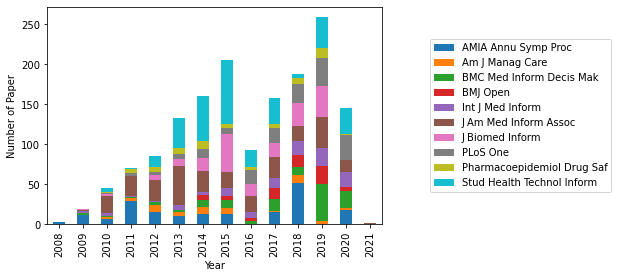

In [5]:
plt.figure(figsize=(15,10))
top_10_journal.groupby(["Publication Year", "Journal/Book"]).size().unstack("Journal/Book").plot.bar(stacked = True)
plt.xticks()
plt.legend(loc ="right", bbox_to_anchor=(1.7, 0.5)) 
plt.xlabel("Year")
plt.ylabel("Number of Paper")
plt.savefig('top_10_journal.jpg', format='jpg', dpi=1200,  bbox_inches='tight') 
plt.show()


<Figure size 1080x720 with 0 Axes>

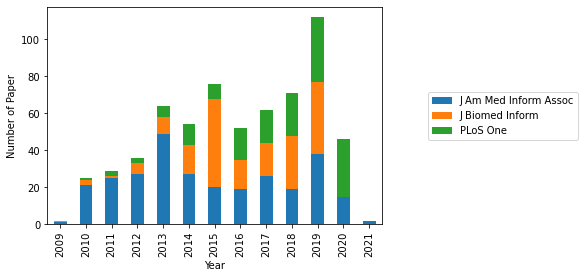

In [6]:
plt.figure(figsize=(15,10))
select_3_journal.groupby(["Publication Year", "Journal/Book"]).size().unstack("Journal/Book").plot.bar(stacked = True)
plt.xticks()
plt.legend(loc ="right", bbox_to_anchor=(1.6, 0.5)) 
plt.xlabel("Year")
plt.ylabel("Number of Paper")
plt.savefig('select_3_journals.jpg', format='jpg', dpi=1200,  bbox_inches='tight') 
plt.show()

In [7]:
select_3_before_2017 = select_3_journal[select_3_journal['Publication Year'].isin(range(2008, 2017))].groupby("Journal/Book").size()
select_3_after_2017 = select_3_journal[select_3_journal['Publication Year'].isin(range(2018, 2021))].groupby("Journal/Book").size()

select_3_before_2017.to_frame().merge(select_3_after_2017.to_frame(), how='inner', on="Journal/Book").rename(columns={"0_x": "2008-2017", "0_y":"2018-2021"})
#select_3_journal.groupby(["Journal/Book", "Publication Year"]).size()

,2008-2017,2018-2021
Journal/Book,,
J Am Med Inform Assoc,189,72
J Biomed Inform,100,68
PLoS One,49,89


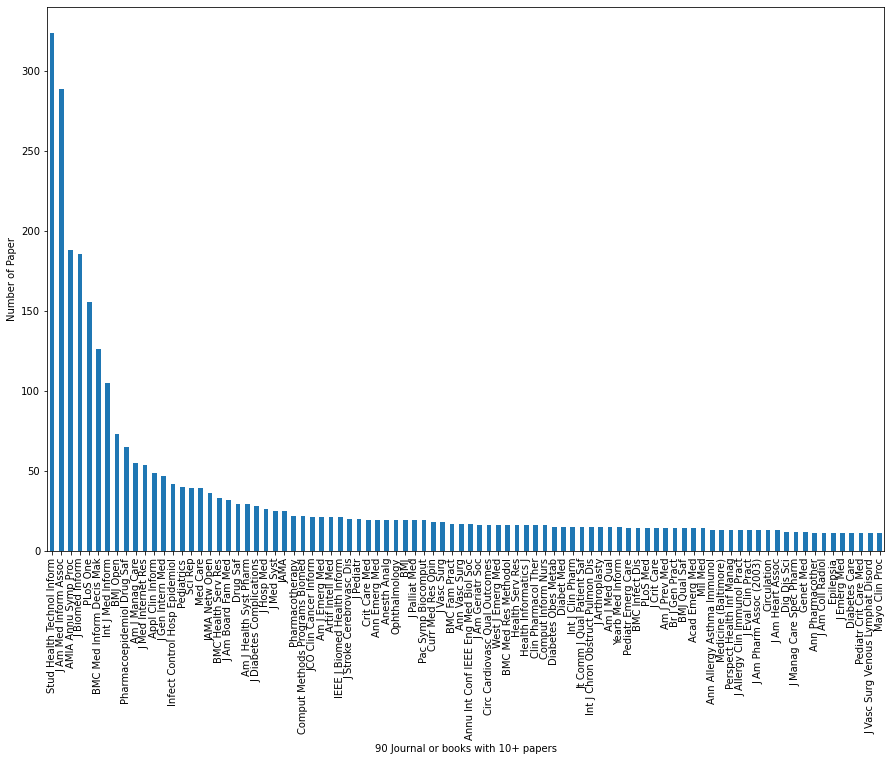

In [8]:
plt.figure(figsize=(15,10))
journal_size[journal_size > 10].sort_values(ascending=False).plot.bar()
plt.xticks()
plt.xlabel("90 Journal or books with 10+ papers")
plt.ylabel("Number of Paper")
plt.show()

# Journals and impact factor 

In [4]:
# get the influence factor of each journal/conference, so filter out a few
from impact_factor import ImpactFactor

if_factor = []

for journal in list(set(df["Journal/Book"])):   
    IF = ImpactFactor()
    if (IF.search(journal) != None):
        if_factor.append(IF.search(journal)['factor'])
    else: 
        if_factor.append(0)


In [5]:
pd.set_option('display.max_rows', None)
pd.options.display.max_rows

In [6]:
merge_factor = pd.DataFrame({'Journal/Book':list(set(df["Journal/Book"])), 'if_factor':if_factor})
merge_factor = merge_factor.sort_values(ascending = False, by='if_factor')
#merge_factor

In [7]:
# fliter out some influence factor == 0
#merge_factor = merge_factor[merge_factor['if_factor'] != 0]
df = pd.merge(df, merge_factor, how='inner', on=['Journal/Book'])

In [8]:
journal = df.groupby("Journal/Book")
len(journal)

1177

In [9]:
journal_df = pd.DataFrame(df.groupby('Journal/Book').size().sort_values(ascending=False))
journal_df = pd.merge(journal_df, merge_factor, how='inner', on=['Journal/Book']).sort_values(ascending=False, by='if_factor')
journal_df = journal_df.rename(columns={0: "count"})
journal_df

,Journal/Book,count,if_factor
387,N Engl J Med,3,74.699
257,Lancet,4,60.392
24,JAMA,25,45.540
177,Nature,6,42.778
456,Science,2,41.845
792,Cell,1,38.637
460,Nat Biotechnol,2,36.558
158,Nat Med,7,36.130
388,Nat Rev Genet,3,33.133
191,J Clin Oncol,6,32.956


In [10]:
journal_df[journal_df['count'] > 10]

,Journal/Book,count,if_factor
24,JAMA,25,45.540
35,BMJ,19,30.223
74,Circulation,13,23.603
83,Diabetes Care,11,16.019
67,PLoS Med,14,10.500
80,Genet Med,12,8.904
39,Ophthalmology,19,8.470
77,J Allergy Clin Immunol Pract,13,7.574
34,Crit Care Med,19,7.414
88,Mayo Clin Proc,11,6.942


### AMIA Annu Symp Proc, n = 188, IF around 1.3 during 2013, but 0.781 in 2018.
### J Biomed Inform, n = 186

In [11]:
df = df.sort_values(by = ["Publication Year", "Journal/Book"])

In [12]:
df.to_csv('main.csv', index = False)

In [161]:
df = pd.read_csv('main.csv')

In [165]:
df['abstract'] = df['abstract'].astype(str).str.replace('\d+', '')

In [168]:
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.strip().split()))
df['abstract_unique_words']= df['abstract'].apply(lambda x:len(set(str(x).split())))
#result.head()

In [174]:
df['abstract'].describe(include='all')

count                                                  5549
unique                                                 5549
top       To examine patterns of, and decision-making pr...
freq                                                      1
Name: abstract, dtype: object

# Remove papers have no abstract

In [175]:
# handle possible duplicates
df.drop_duplicates(['abstract'], inplace=True)
df['abstract'].describe(include='all')

count                                                  5549
unique                                                 5549
top       To examine patterns of, and decision-making pr...
freq                                                      1
Name: abstract, dtype: object

In [176]:
df = df[df['abstract_word_count'] != 0]

# NLP

In [177]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm  # model downloaded in previous step

In [178]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['everywhere',
 'my',
 'would',
 'has',
 'really',
 'these',
 'beforehand',
 'hers',
 'still',
 'all']

In [179]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [180]:
# Parser

parser = en_core_web_sm.load(disable=["tagger", "ner", "lemmatizer"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [181]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

tqdm.pandas()
df["processed_text"] = df["abstract"].progress_apply(spacy_tokenizer)

/Users/siyueyang/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 5549/5549 [00:50<00:00, 110.05it/s]


In [182]:
import seaborn as sns

count    5549.000000
mean       88.249955
std        75.842590
min         1.000000
25%        34.000000
50%        57.000000
75%       129.000000
max       481.000000
Name: abstract_word_count, dtype: float64

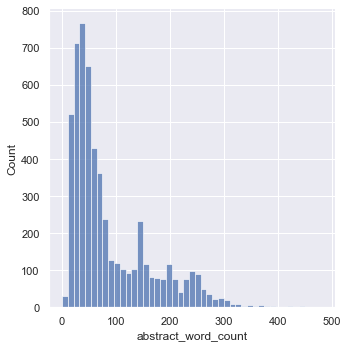

In [183]:
sns.displot(df['abstract_word_count'])
df['abstract_word_count'].describe()

count    5549.000000
mean       63.361507
std        44.007838
min         1.000000
25%        31.000000
50%        47.000000
75%        91.000000
max       248.000000
Name: abstract_unique_words, dtype: float64

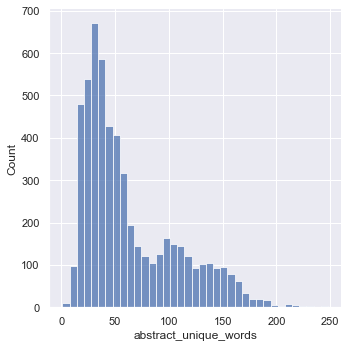

In [184]:
sns.displot(df['abstract_unique_words'])
df['abstract_unique_words'].describe()

# Vectorization

In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [186]:
text = df['abstract'].values
X = vectorize(text, 2 ** 12)
X.shape

(5549, 4096)

# PCA & Clustering
Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data.

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data.

In [187]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(5549, 2344)

# K-means
To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [188]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

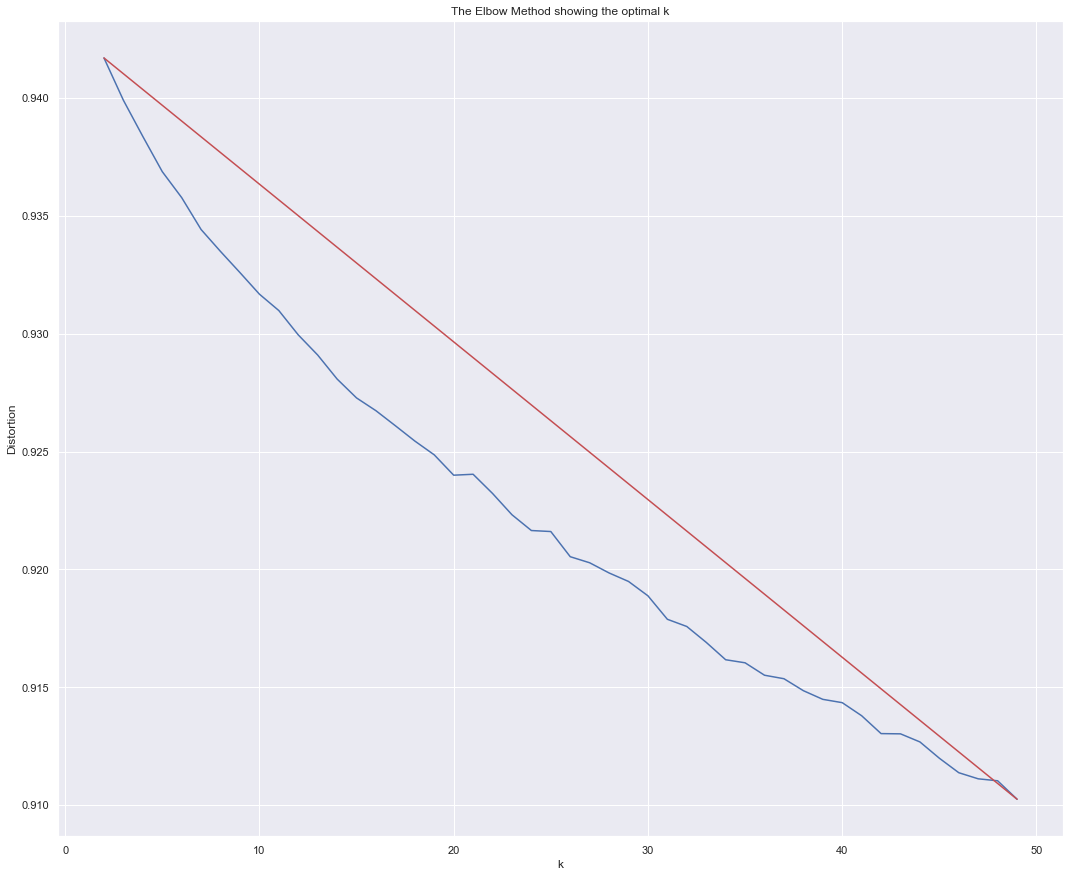

In [190]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [191]:
k = 15
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

# Dimensionality Reduction with t-SNE
Using t-SNE we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted.


t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space

In [192]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5549 samples in 2.040s...
[t-SNE] Computed neighbors for 5549 samples in 206.413s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5549
[t-SNE] Computed conditional probabilities for sample 2000 / 5549
[t-SNE] Computed conditional probabilities for sample 3000 / 5549
[t-SNE] Computed conditional probabilities for sample 4000 / 5549
[t-SNE] Computed conditional probabilities for sample 5000 / 5549
[t-SNE] Computed conditional probabilities for sample 5549 / 5549
[t-SNE] Mean sigma: 0.389036
[t-SNE] KL divergence after 250 iterations with early exaggeration: 119.622131
[t-SNE] KL divergence after 1000 iterations: 3.475605


/Users/siyueyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


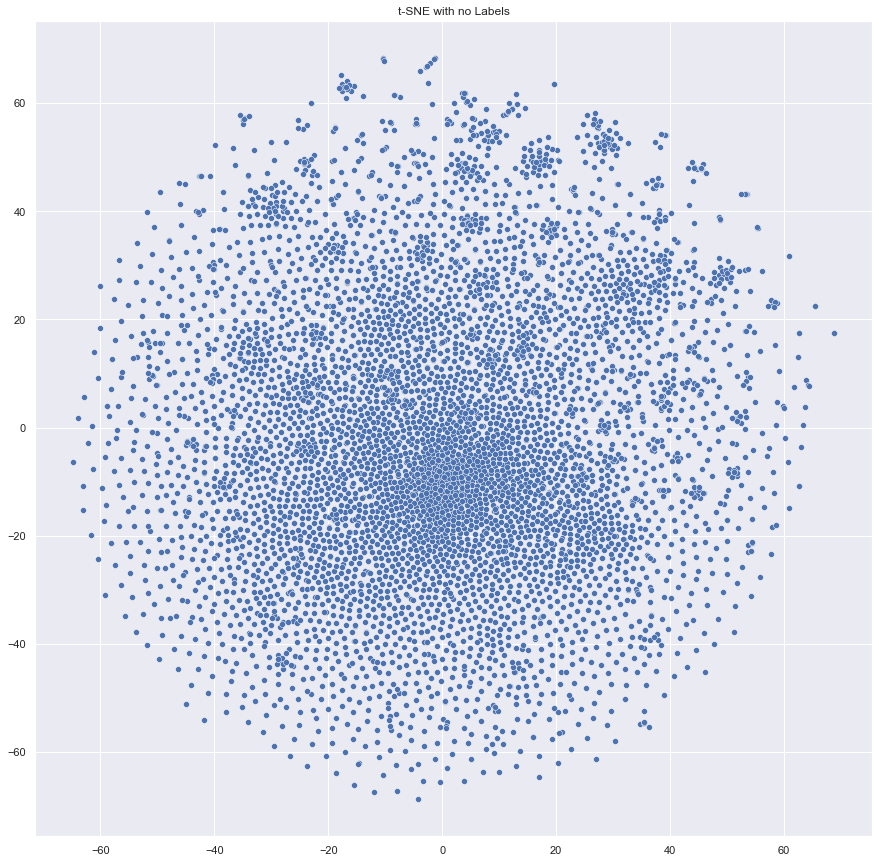

In [195]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

/Users/siyueyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


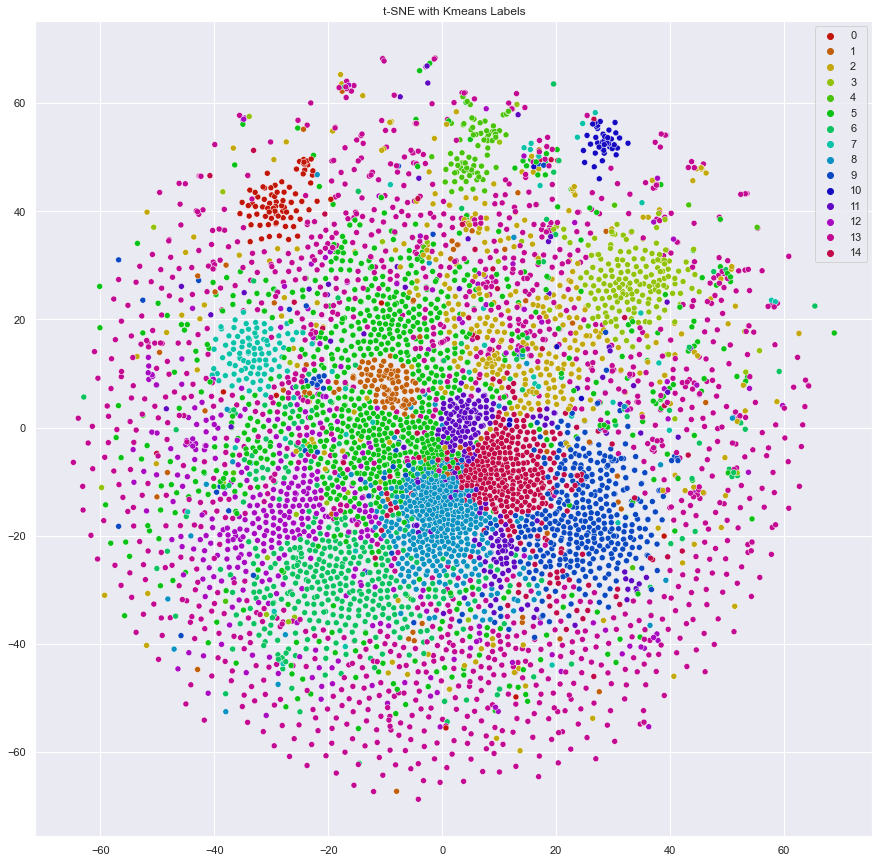

In [211]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(15, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

# Topic modeling on each cluster
For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words.

In [218]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [259]:
# First we will create 15 vectorizers, one for each of our cluster labels

vectorizers = []
    
for ii in range(0, 15):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(stop_words='english', token_pattern='(?u)\\b\\w+\\b'))

In [260]:
vectorizers[0].fit_transform(df.loc[df['y'] == 0, 'abstract'])

<86x1389 sparse matrix of type '<class 'numpy.int64'>'
	with 3296 stored elements in Compressed Sparse Row format>

In [261]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'abstract']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [262]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 15

lda_models = []
for ii in range(0, 15):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=15,
                          random_state=42, verbose=False)

In [263]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [264]:
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [265]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [269]:
all_keywords[2][:10]

['patients',
 'covid',
 'risk',
 'factors',
 'suicide',
 'caries',
 'tachycardia',
 'hit',
 'fracture',
 'cv']

In [270]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [271]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_keywords.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(15)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

# Classify

In [272]:
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [273]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 4439
X_test size: 1110 



In [274]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  83.758 %
     Precision:  87.493 %
        Recall:  83.475 %
      F1 score:  85.260 %


In [275]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  74.595 %
     Precision:  84.547 %
        Recall:  65.572 %
      F1 score:  71.588 %


In [276]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 86.195 %


# Plotting data 

In [277]:
from call_backs import input_callback, selected_code  # file with customJS callbacks for bokeh
                                                      # github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/lib/call_backs.py
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

ModuleNotFoundError: No module named 'call_backs'

In [28]:
def contains_word(s, w):
    return f' {w} ' in f' {s} '

In [278]:
df['NLP'] = df['abstract'].apply(lambda x: int(contains_word(x, "NLP")) + int(contains_word(x, "natural language processing")))
df['NLP'] = df['NLP'] + df['Title'].apply(lambda x: int(contains_word(x, "NLP")) + int(contains_word(x, "natural language processing")))

In [291]:
df['review'] = df['Title'].apply(lambda x: int(contains_word(x, "review")) + int(contains_word(x, "guide")))
df['chart review'] = df['abstract'].apply(lambda x: int(contains_word(x, "chart review")))
df['supervised'] = df['abstract'].apply(lambda x: int(contains_word(x, "supervised")))
df['unsupervised'] = df['abstract'].apply(lambda x: int(contains_word(x, "unsupervised")))
df['semisupervsied'] = df['abstract'].apply(lambda x: int(contains_word(x, "semisupervised")) + int(contains_word(x, "semi-supervised")))
df['rule'] = df['abstract'].apply(lambda x: int(contains_word(x, "rule-based")))

# Reviews, n = 69

In [292]:
reviews_list = df[df['review'] > 0]
#for every in reviews_list['Title']:
#    print(every)
print(len(reviews_list))
#reviews_list.groupby('Publication Year').size().sort_values(ascending=False)

76


# NLP, n = 236

In [293]:
NLP_list = df[df['NLP'] > 0]
print(len(NLP_list))
NLP_list.groupby('Publication Year').size().sort_values(ascending=False)

370


Publication Year
2019    87
2018    45
2015    44
2017    39
2020    34
2013    29
2014    24
2016    19
2011    19
2012    16
2010    12
2009     2
dtype: int64

In [303]:
supervised_list = df[df['supervised'] > 0]
unsupervised_list = df[df['unsupervised'] > 0]
semi_list = df[df['semisupervsied'] > 0]

In [297]:
def count_in_years(lists):
    year_count = []
    for year in range(2008, 2021):
        target_pd = lists.groupby('Publication Year').size()
        if (year not in set(target_pd.keys())):
            year_count.append(0)
        else:
            year_count.append(target_pd[year])
    return year_count
#NLP_list.groupby('Publication Year').size().keys

In [298]:
count_in_years(NLP_list)

[0, 2, 12, 19, 16, 29, 24, 44, 19, 39, 45, 87, 34]

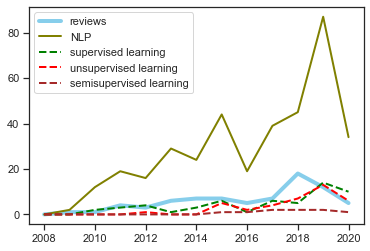

In [305]:
# Data
df_plot = pd.DataFrame({'year': range(2008, 2021), 'NLP': count_in_years(NLP_list), 
                 'reviews': count_in_years(reviews_list), 'supervised learning': count_in_years(supervised_list),
                'unsupervised learning': count_in_years(unsupervised_list),
                 'semisupervised learning': count_in_years(semi_list)})
 
# multiple line plots
plt.plot('year', 'reviews', data=df_plot, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot('year', 'NLP', data=df_plot, marker='', color='olive', linewidth=2)
plt.plot('year', 'supervised learning', data=df_plot, marker='', color='green', linewidth=2, linestyle='dashed')
plt.plot('year', 'unsupervised learning', data=df_plot, marker='', color='red', linewidth=2, linestyle='dashed')
plt.plot('year', 'semisupervised learning', data=df_plot, marker='', color='brown', linewidth=2, linestyle='dashed')
# show legend
plt.legend()

# show graph

plt.savefig('NLP_mentions.jpg', format='jpg', dpi=1200) 
plt.show()

# Step 3: Link the paper to their body using the `metapub` package

In [132]:
from metapub import PubMedFetcher
from metapub import FindIt

pmids = [30617335]
for pmid in pmids:
    src = FindIt(pmid)
    print(src.doi)
    print(src.url)

10.1038/s41591-018-0316-z
None


In [133]:
fetch = PubMedFetcher()
article = fetch.article_by_pmid('30617335')
print(article.title)
print(article.journal, article.year, article.volume, article.issue)
print(article.authors)
print(article.citation)

A guide to deep learning in healthcare.
Nat Med 2019 25 1
['Esteva A', 'Robicquet A', 'Ramsundar B', 'Kuleshov V', 'DePristo M', 'Chou K', 'Cui C', 'Corrado G', 'Thrun S', 'Dean J']
Esteva A, et al. A guide to deep learning in healthcare. A guide to deep learning in healthcare. 2019; 25:24-29. doi: 10.1038/s41591-018-0316-z


In [135]:
print(article)

<PubMedArticle 30617335> Esteva A; Robicquet A; Ramsundar B; Kuleshov V; DePristo M; Chou K; Cui C; Corrado G; Thrun S; Dean J. A guide to deep learning in healthcare.. Nat Med. 2019. 25(1):24-29


In [187]:

src = FindIt('28729030')
print(src.url)

http://europepmc.org/backend/ptpmcrender.fcgi?accid=PMC6864736&blobtype=pdf


In [183]:
src = FindIt('30617335')
if src.url is None: print(src.reason)

    
s = src.reason
s[s.find("(")+1:s.find(")")]

DENIED: Nature url (https://www.nature.com/articles/s41591-018-0316-z) did not result in a PDF


'https://www.nature.com/articles/s41591-018-0316-z'

In [225]:
src = FindIt('30617335')
print(src.url)

None


In [218]:
# find some element by id 
#kw = driver.find_element_by_id('term')
# enter something to the input box
#kw.send_keys("electronic health records")
#driver.find_element_by_id('search').click()

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options


url=src.url

download_dir = "/Users/siyueyang/Downloads/downloaded_reviews"

chrome_options = Options()
chrome_options.add_experimental_option('prefs',  {
    "download.default_directory": download_dir,
    "download.prompt_for_download": False,
    "download.directory_upgrade": True,
    "plugins.always_open_pdf_externally": True
    }
)

browser = webdriver.Chrome(options = chrome_options)

browser.get(url)

In [214]:
import os
import time

In [215]:
newname = "30617335.pdf"
filename = max([f for f in os.listdir(download_dir)], key=lambda xa : os.path.getctime(os.path.join(download_dir,xa)))
os.rename(os.path.join(download_dir, filename), os.path.join(download_dir, newname))
     

## Word cloud

In [ ]:
text = " ".join(review for review in result.abstract)
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["used", "data"])



# genearte word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      collocations=False, stopwords = stopwords, 
                      background_color='salmon', colormap='Pastel1').generate(text)


#wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(dpi=1200)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.savefig('word_cloud.jpg', format='jpg', dpi=1200)
plt.show()